## Import Modules/Libraries

## Setup Paths and other parameters

This is the main cell to change the parameters and imaging paths around.

In [1]:

#Cell -1
import tensorflow
import tensorflow as tf
from tensorflow.keras.applications import vgg16, efficientnet, EfficientNetV2S
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Convolution2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras import metrics
from tensorflow.keras.regularizers import l1
from keras.callbacks import ReduceLROnPlateau
import cv2
from PIL import Image
#
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
#
from pathlib import Path
import pandas as pd
import numpy as np
#
from datetime import datetime
import os
import platform
#
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print('Tensorflow Version: ',tensorflow.__version__)
print('tf.keras Version  : ',tensorflow.keras.__version__)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5387064568647640326
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 23261282304
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15171669179354940944
physical_device_desc: "device: 0, name: Quadro RTX 6000, pci bus id: 0000:d5:00.0, compute capability: 7.5"
xla_global_id: 416903419
]
Tensorflow Version:  2.9.1
tf.keras Version  :  2.9.0


In [2]:
#Cell 0

# %cd C:\Users\Developer\MyProjects\ROP_Plus\ROP_Plus_NoPlus



def change_directory(path):
    try:
        # Change to the specified directory
        os.chdir(path)
        print(f"Changed directory to: {os.getcwd()}")
    except FileNotFoundError:
        print(f"The directory {path} does not exist.")
    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage
if __name__ == "__main__":
    # Define the path for both Windows and Linux
    if platform.system() == "Windows":
        path = r"C:\Users\Developer\MyProjects\DR_Fundus_Study\DR_Fundus"  # Raw string for Windows
    else:
        path = "/home/developer/Documents/MyProjects/DR_Fundus_Study/DR_Fundus"  # Linux path

    change_directory(path)


Changed directory to: C:\Users\Developer\MyProjects\DR_Fundus_Study\DR_Fundus


In [3]:

ClassNameVar = 'Retinopathy grade'
#Cell 1
fold_num = 1
LayerName = 'RGB'
X_col = 'Image name'
epochs = 80 

#
# Image size
# img_width, img_height, img_depth = 480, 640, 3
img_width, img_height, img_depth = 640, 420, 3
#
# Data organization - Training Data
#     ColorName = 'RGB/'
data_dir = Path(('../Dataset/PreProcessedImages/' + LayerName + '_OutputFinal/'))
csv_dir = Path('../Dataset')
csv_name = 'train' + str(fold_num) + '.csv'
csv_path = csv_dir / csv_name
df_train = pd.read_csv(csv_path)


df_train = df_train.sample(frac = 1, random_state = fold_num)
#
# Data organization - Validation and Testing Data
valid_data_dir = Path(('../Dataset/PreProcessedImages/' + LayerName + '_OutputFinal/'))
csv_dir = Path('../Dataset')
csv_name = 'valid' + str(fold_num) + '.csv'
csv_path = csv_dir / csv_name
df_valid = pd.read_csv(csv_path)


####Unseen
unseen_data_dir = Path(('../Dataset/PreProcessedImages/' + LayerName + '_OutputFinal/'))
csv_dir = Path('../Dataset')
csv_name = 'testDR' +'.csv'
csv_path = csv_dir / csv_name
df_unseen = pd.read_csv(csv_path)


# ###

# #external
# test_data_dir = Path(('../Dataset/PreProcessedImages/' + LayerName + '_Channel/'))
# csv_dir = Path('../Dataset')
# csv_name = 'externalDataset' +'.xlsx'
# csv_path = csv_dir / csv_name
# df_test = pd.read_excel(csv_path)


class_names = ['DR_0','DR_1','DR_2','DR_3'] # Used for the confusion matrix at the end



# Training parameters
                    # For fitting the model
freq = epochs // 2              # For saving the model

batch_size = 16 #len(df_train)               # For fitting the model/ data augmentation parameters
batch_size_valid = 16             # For fitting the model/ data augmentation parameters

# if fold_num == 3 :
#   batch_size = 48                 # For fitting the model/ data augmentation parameters
#   batch_size_valid = 12            # For fitting the model/ data augmentation parameters

num_classes = len(class_names)                 # For the model architecture
train_valid_split = 0.2        # For data-augmentation parameters
#
# Learning rate
learning_rate = 0.00001         # For fitting the model
#
# This is the different layers and their corresponding information
# Layer Number | Name of Layer | Output size | Number of parameters
# -8 block4_conv1 (Conv2D)        (None, 38, 38, 512)       1180160
# _________________________________________________________________
# -7 block4_conv2 (Conv2D)        (None, 38, 38, 512)       2359808
# _________________________________________________________________
# -6 block4_conv3 (Conv2D)        (None, 38, 38, 512)       2359808
# _________________________________________________________________
# -5 block4_pool (MaxPooling2D)   (None, 19, 19, 512)       0
# _________________________________________________________________
# -4 block5_conv1 (Conv2D)        (None, 19, 19, 512)       2359808
# _________________________________________________________________
# -3 block5_conv2 (Conv2D)        (None, 19, 19, 512)       2359808
# _________________________________________________________________
# -2 block5_conv3 (Conv2D)        (None, 19, 19, 512)       2359808
# _________________________________________________________________
# -1 block5_pool (MaxPooling2D)   (None, 9, 9, 512)         0
#
# Transfer learning layers
train_false_layer = -16 # Based on the Layer Number.
#
# I automated this part for binary or non-binary classification.
if num_classes < 2:
    act_type = 'sigmoid'
    class_mode = 'binary'
    loss_fun = 'binary_crossentropy'
else:
    act_type = 'softmax'
    class_mode = 'categorical'
    loss_fun = 'categorical_crossentropy'
#
print('Type of classification: ', class_mode)
print('Loss function: ', loss_fun)
print('Activation function: ', act_type)
len(df_train)

Type of classification:  categorical
Loss function:  categorical_crossentropy
Activation function:  softmax


800

In [4]:
pwd

'C:\\Users\\Developer\\MyProjects\\DR_Fundus_Study\\DR_Fundus'

Found 800 validated image filenames belonging to 4 classes.
Found 200 validated image filenames belonging to 4 classes.


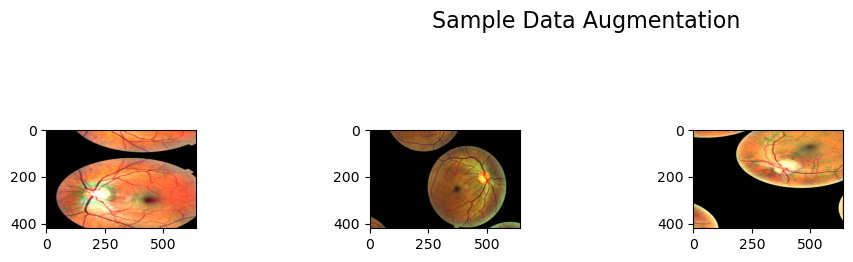

y Labels:  [[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]
sample img, max value:  1.0
sample img, min value:  0.0


In [5]:
#

#Cell 2


data_gen_args = dict(
rescale = 1./255,
brightness_range = [0.5,1.5],
horizontal_flip = True,
vertical_flip = True,
rotation_range = 45.,
zoom_range = 0.4,
height_shift_range = 0.1,
width_shift_range = 0.1,
shear_range = 0.3,

# featurewise_center = True,
# featurewise_std_normalization = True,
# samplewise_std_normalization= True,
# samplewise_center=True,
fill_mode = 'reflect'
# validation_split=train_valid_split
)






# Add Gaussian noise
class ImageDataGeneratorWithNoise(ImageDataGenerator):
    def __init__(self, noise_stddev=0.1, **kwargs):
        super().__init__(**kwargs)
        self.noise_stddev = noise_stddev

    def random_transform(self, x, seed=None):
        x = super().random_transform(x, seed)
        noise = np.random.normal(loc=0, scale=self.noise_stddev, size=x.shape)
        x = x + noise
        x = np.clip(x, 0., 1.)
        return x

# Custom preprocessing function to adjust contrast, saturation, and hue shift
# def contrast_stretching_(img):
#   # Split the image into individual channels
#   channels = cv2.split(img)

#   # Apply contrast stretching on each channel separately
#   stretched_channels = []
#   for channel in channels:
#       min_val, max_val = np.min(channel), np.max(channel)
#       stretched_channel = ((channel - min_val) * (255.0 / (max_val - min_val)))
#       stretched_channels.append(stretched_channel)

#   # Concatenate the stretched channels back to RGB image
#   stretched_img = cv2.merge(stretched_channels)

#   return stretched_img


datagen = ImageDataGenerator(
    **data_gen_args
    # preprocessing_function = contrast_stretching_
    )
#
# Train data generator
train_generator = datagen.flow_from_dataframe(
    dataframe = df_train,
    directory = data_dir,
    x_col = X_col, #LayerName,
    y_col = ClassNameVar,
    seed= 123,
    # subset = 'training',
#     target_size = (img_width, img_height),
    target_size = (img_height, img_width),
    class_mode = class_mode,
    color_mode = 'rgb',
    batch_size = batch_size,
    shuffle = True)
#
# Validation data generator
valid_data_gen_args = dict(
    rescale = 1./255,
)

valid_datagen = ImageDataGenerator(
    **valid_data_gen_args)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe = df_valid,
    directory = valid_data_dir,
    x_col =  X_col, #LayerName,
    y_col = ClassNameVar,
    seed=123,
    # subset = 'validation',
#     target_size = (img_width, img_height),
    target_size = (img_height, img_width),
    class_mode = class_mode,
    color_mode = 'rgb',
    batch_size = batch_size_valid,
    shuffle = True)
#
# Preview the augmented data
X_preview, y_preview = train_generator.next()
#
if not os.path.isdir('../Dataset/Augmented_Samples'):
    os.mkdir('../Dataset/Augmented_Samples')

# Create a larger figure with specified size
plt.figure(figsize=(16, 12))  # Adjust the width (12) and height (8) as needed

for k in range(1,4):
    sample_img = X_preview[k,:,:,:]
    img = Image.fromarray((sample_img * 255).astype('uint8'))  # Convert image array to PIL Image

    image_class = class_names[np.argmax(y_preview[k])]

    img.save(f'../Dataset/Augmented_Samples/image_{k}_'+image_class+'.png')  # Save the image as PNG


    plt.subplot(8, 4, k)
    plt.imshow(sample_img)

plt.suptitle('Sample Data Augmentation', fontsize = 16)
plt.show()
#
print('y Labels: ', y_preview[1:5])
print('sample img, max value: ',np.max(sample_img))
print('sample img, min value: ',np.min(sample_img))


In [6]:
y_preview[0]

array([1., 0., 0., 0.], dtype=float32)

In [7]:
#Cell 3

# Preview the augmented data
X_preview_val, y_preview_val = valid_generator.next()

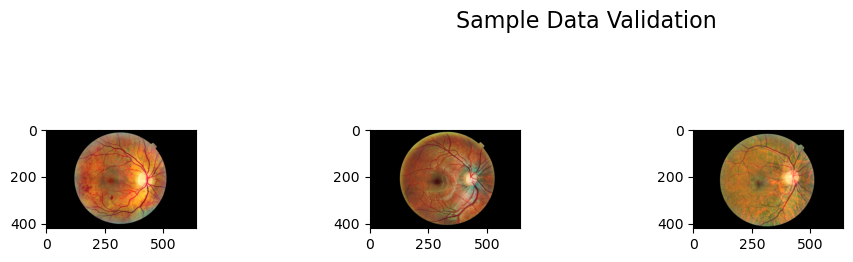

y Labels:  [[0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]]
sample img, max value:  1.0
sample img, min value:  0.0


In [8]:




#Cell 4


if not os.path.isdir('../Dataset/Validation_Samples'):
    os.mkdir('../Dataset/Validation_Samples')

# Create a larger figure with specified size
plt.figure(figsize=(16, 12))  # Adjust the width (12) and height (8) as needed
for k in range(1,4):


    sample_img = X_preview_val[k,:,:,:]
    img = Image.fromarray((sample_img * 255).astype('uint8'))  # Convert image array to PIL Image
    image_class = class_names[np.argmax(y_preview_val[k])]

    img.save(f'../Dataset/Validation_Samples/image_{k}_'+image_class+'.png')  # Save the image as PNG
    plt.subplot(8, 4, k)
    plt.imshow(sample_img)
plt.suptitle('Sample Data Validation', fontsize = 16)
plt.show()

#
print('y Labels: ', y_preview_val[1:5])
print('sample img, max value: ',np.max(sample_img))
print('sample img, min value: ',np.min(sample_img))



In [9]:

#########################Distribute####################################
#Cell 5
#     strategy = tf.distribute.MirroredStrategy()
#     print("Number of devices: {}".format(strategy.num_replicas_in_sync))

from keras.layers import Lambda
from tensorflow.keras.layers import Concatenate

def filterChannel(inputDataFromPrevLayer, maskIn = [1,1,1]):
    branch_outputs = []
    mask = maskIn
    for i in range(img_depth):
        if i == 0:
            out = inputDataFromPrevLayer[:,:,:,0]*mask[i]
        elif i == 1:
            out = inputDataFromPrevLayer[:,:,:,1]*mask[i]
        elif i == 2:
            out = inputDataFromPrevLayer[:,:,:,2]*mask[i]

        # out = inputDataFromPrevLayer[:,:,:,i]*mask[i]
        branch_outputs.append(tf.expand_dims(out, axis=-1))

    return Concatenate(axis = -1)(branch_outputs)

import inspect
filterChannelFuncRepr, filterChannelLine_no = inspect.getsourcelines(filterChannel)


In [10]:

#Cell 6


# Build Model
# image_input = Input(shape = (img_width, img_height, img_depth))
image_input = Input(shape = (img_height, img_width, img_depth))

baseModeInput = Lambda(filterChannel)(image_input, [1,1,1])


base_model = EfficientNetV2S(
    input_tensor = baseModeInput,
    include_top = False,
    weights = 'imagenet'
)
#
base_output = base_model.layers[-1].output
#
# flat1 = Flatten()(base_output)
flat1 = tf.keras.layers.GlobalAveragePooling2D()(base_output)
dropOutflat = Dropout(0.1)(flat1)
fc1 = Dense(1000, activation = 'relu')(dropOutflat)
# dropfc1 = Dropout(0.1)(fc1)
#     fc2 = Dense(1024, activation = 'relu')(fc1)
# dropfc2 = Dropout(0.2)(fc2)
# fc3 = Dense(999, activation = 'relu')(dropfc2)
output = Dense(num_classes, activation = act_type)(fc1)
#
# for layer in base_model.layers[:train_false_layer]:
#     layer.trainable = False
model = Model(image_input, output)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 420, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 420, 640, 3)  0           ['input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 420, 640, 3)  0           ['lambda[0][0]']                 
                                                                                                  
 stem_conv (Conv2D)             (None, 210, 320, 24  648         ['rescaling[0][0]']          

 block2c_expand_conv (Conv2D)   (None, 105, 160, 19  82944       ['block2b_add[0][0]']            
                                2)                                                                
                                                                                                  
 block2c_expand_bn (BatchNormal  (None, 105, 160, 19  768        ['block2c_expand_conv[0][0]']    
 ization)                       2)                                                                
                                                                                                  
 block2c_expand_activation (Act  (None, 105, 160, 19  0          ['block2c_expand_bn[0][0]']      
 ivation)                       2)                                                                
                                                                                                  
 block2c_project_conv (Conv2D)  (None, 105, 160, 48  9216        ['block2c_expand_activation[0][0]
          

 block3c_project_conv (Conv2D)  (None, 53, 80, 64)   16384       ['block3c_expand_activation[0][0]
                                                                 ']                               
                                                                                                  
 block3c_project_bn (BatchNorma  (None, 53, 80, 64)  256         ['block3c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block3c_drop (Dropout)         (None, 53, 80, 64)   0           ['block3c_project_bn[0][0]']     
                                                                                                  
 block3c_add (Add)              (None, 53, 80, 64)   0           ['block3c_drop[0][0]',           
                                                                  'block3b_add[0][0]']            
          

                                                                                                  
 block4b_se_reshape (Reshape)   (None, 1, 1, 512)    0           ['block4b_se_squeeze[0][0]']     
                                                                                                  
 block4b_se_reduce (Conv2D)     (None, 1, 1, 32)     16416       ['block4b_se_reshape[0][0]']     
                                                                                                  
 block4b_se_expand (Conv2D)     (None, 1, 1, 512)    16896       ['block4b_se_reduce[0][0]']      
                                                                                                  
 block4b_se_excite (Multiply)   (None, 27, 40, 512)  0           ['block4b_activation[0][0]',     
                                                                  'block4b_se_expand[0][0]']      
                                                                                                  
 block4b_p

 block4d_se_expand (Conv2D)     (None, 1, 1, 512)    16896       ['block4d_se_reduce[0][0]']      
                                                                                                  
 block4d_se_excite (Multiply)   (None, 27, 40, 512)  0           ['block4d_activation[0][0]',     
                                                                  'block4d_se_expand[0][0]']      
                                                                                                  
 block4d_project_conv (Conv2D)  (None, 27, 40, 128)  65536       ['block4d_se_excite[0][0]']      
                                                                                                  
 block4d_project_bn (BatchNorma  (None, 27, 40, 128)  512        ['block4d_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4d_d

 block4f_project_conv (Conv2D)  (None, 27, 40, 128)  65536       ['block4f_se_excite[0][0]']      
                                                                                                  
 block4f_project_bn (BatchNorma  (None, 27, 40, 128)  512        ['block4f_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4f_drop (Dropout)         (None, 27, 40, 128)  0           ['block4f_project_bn[0][0]']     
                                                                                                  
 block4f_add (Add)              (None, 27, 40, 128)  0           ['block4f_drop[0][0]',           
                                                                  'block4e_add[0][0]']            
                                                                                                  
 block5a_e

 block5c_expand_conv (Conv2D)   (None, 27, 40, 960)  153600      ['block5b_add[0][0]']            
                                                                                                  
 block5c_expand_bn (BatchNormal  (None, 27, 40, 960)  3840       ['block5c_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5c_expand_activation (Act  (None, 27, 40, 960)  0          ['block5c_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block5c_dwconv2 (DepthwiseConv  (None, 27, 40, 960)  8640       ['block5c_expand_activation[0][0]
 2D)                                                             ']                               
          

 block5e_expand_activation (Act  (None, 27, 40, 960)  0          ['block5e_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block5e_dwconv2 (DepthwiseConv  (None, 27, 40, 960)  8640       ['block5e_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block5e_bn (BatchNormalization  (None, 27, 40, 960)  3840       ['block5e_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block5e_activation (Activation  (None, 27, 40, 960)  0          ['block5e_bn[0][0]']             
 )        

                                                                                                  
 block5g_bn (BatchNormalization  (None, 27, 40, 960)  3840       ['block5g_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block5g_activation (Activation  (None, 27, 40, 960)  0          ['block5g_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5g_se_squeeze (GlobalAver  (None, 960)         0           ['block5g_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5g_s

 )                                                                                                
                                                                                                  
 block5i_se_squeeze (GlobalAver  (None, 960)         0           ['block5i_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5i_se_reshape (Reshape)   (None, 1, 1, 960)    0           ['block5i_se_squeeze[0][0]']     
                                                                                                  
 block5i_se_reduce (Conv2D)     (None, 1, 1, 40)     38440       ['block5i_se_reshape[0][0]']     
                                                                                                  
 block5i_se_expand (Conv2D)     (None, 1, 1, 960)    39360       ['block5i_se_reduce[0][0]']      
          

 block6b_se_expand (Conv2D)     (None, 1, 1, 1536)   99840       ['block6b_se_reduce[0][0]']      
                                                                                                  
 block6b_se_excite (Multiply)   (None, 14, 20, 1536  0           ['block6b_activation[0][0]',     
                                )                                 'block6b_se_expand[0][0]']      
                                                                                                  
 block6b_project_conv (Conv2D)  (None, 14, 20, 256)  393216      ['block6b_se_excite[0][0]']      
                                                                                                  
 block6b_project_bn (BatchNorma  (None, 14, 20, 256)  1024       ['block6b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6b_d

                                )                                 'block6d_se_expand[0][0]']      
                                                                                                  
 block6d_project_conv (Conv2D)  (None, 14, 20, 256)  393216      ['block6d_se_excite[0][0]']      
                                                                                                  
 block6d_project_bn (BatchNorma  (None, 14, 20, 256)  1024       ['block6d_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6d_drop (Dropout)         (None, 14, 20, 256)  0           ['block6d_project_bn[0][0]']     
                                                                                                  
 block6d_add (Add)              (None, 14, 20, 256)  0           ['block6d_drop[0][0]',           
          

                                                                                                  
 block6f_project_bn (BatchNorma  (None, 14, 20, 256)  1024       ['block6f_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6f_drop (Dropout)         (None, 14, 20, 256)  0           ['block6f_project_bn[0][0]']     
                                                                                                  
 block6f_add (Add)              (None, 14, 20, 256)  0           ['block6f_drop[0][0]',           
                                                                  'block6e_add[0][0]']            
                                                                                                  
 block6g_expand_conv (Conv2D)   (None, 14, 20, 1536  393216      ['block6f_add[0][0]']            
          

                                                                                                  
 block6h_drop (Dropout)         (None, 14, 20, 256)  0           ['block6h_project_bn[0][0]']     
                                                                                                  
 block6h_add (Add)              (None, 14, 20, 256)  0           ['block6h_drop[0][0]',           
                                                                  'block6g_add[0][0]']            
                                                                                                  
 block6i_expand_conv (Conv2D)   (None, 14, 20, 1536  393216      ['block6h_add[0][0]']            
                                )                                                                 
                                                                                                  
 block6i_expand_bn (BatchNormal  (None, 14, 20, 1536  6144       ['block6i_expand_conv[0][0]']    
 ization) 

 block6j_add (Add)              (None, 14, 20, 256)  0           ['block6j_drop[0][0]',           
                                                                  'block6i_add[0][0]']            
                                                                                                  
 block6k_expand_conv (Conv2D)   (None, 14, 20, 1536  393216      ['block6j_add[0][0]']            
                                )                                                                 
                                                                                                  
 block6k_expand_bn (BatchNormal  (None, 14, 20, 1536  6144       ['block6k_expand_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 block6k_expand_activation (Act  (None, 14, 20, 1536  0          ['block6k_expand_bn[0][0]']      
 ivation) 

 block6m_expand_conv (Conv2D)   (None, 14, 20, 1536  393216      ['block6l_add[0][0]']            
                                )                                                                 
                                                                                                  
 block6m_expand_bn (BatchNormal  (None, 14, 20, 1536  6144       ['block6m_expand_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 block6m_expand_activation (Act  (None, 14, 20, 1536  0          ['block6m_expand_bn[0][0]']      
 ivation)                       )                                                                 
                                                                                                  
 block6m_dwconv2 (DepthwiseConv  (None, 14, 20, 1536  13824      ['block6m_expand_activation[0][0]
 2D)      

 block6o_expand_bn (BatchNormal  (None, 14, 20, 1536  6144       ['block6o_expand_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 block6o_expand_activation (Act  (None, 14, 20, 1536  0          ['block6o_expand_bn[0][0]']      
 ivation)                       )                                                                 
                                                                                                  
 block6o_dwconv2 (DepthwiseConv  (None, 14, 20, 1536  13824      ['block6o_expand_activation[0][0]
 2D)                            )                                ']                               
                                                                                                  
 block6o_bn (BatchNormalization  (None, 14, 20, 1536  6144       ['block6o_dwconv2[0][0]']        
 )        

In [11]:


#Cell 7

# Compile the model
METRICS = [
    metrics.TruePositives(name='tp'),
    # metrics.FalsePositives(name='fp'),
    # metrics.TrueNegatives(name='tn'),
    # metrics.FalseNegatives(name='fn'),
    metrics.CategoricalAccuracy(name='accuracy'),


    # metrics.Precision(name='precision'),
    # metrics.Recall(name='recall'),
    # metrics.AUC(name='auc'),
    # metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

opt = Adam(learning_rate = learning_rate)
#
model.compile(
    loss = loss_fun,
    optimizer = opt,
    # metrics = ['accuracy']
    metrics= METRICS
)

################################Distribute###############################


###### add load model
# checkpoint_path = Path('loadFile/fold_num_'+str(fold_num)+'early_stop_model.hdf5')
# model.load_weights(checkpoint_path)



In [12]:
loss_fun

'categorical_crossentropy'

In [13]:
#Cell 8

# Folder setup
if not os.path.isdir('Results'):
    os.mkdir('Results')

init_time = datetime.now()
current_time = init_time.strftime('%Y%m%d_%H%M%S')
name_dir = 'Results/trained_models_' + current_time + '_fold_num' + str(fold_num) + '_' + str(LayerName)
os.makedirs(name_dir, exist_ok=True)
#
## Callbacks1: ModelCheckpointer
# model_file_format = name_dir + '/model_' + str(fold_num) + '_model.{epoch:04d}.hdf5'
# check = ModelCheckpoint(
#     model_file_format,
#     save_freq = freq, # The 'freq' parameter is defined previously as "epoch // 2", I want to save 2 model weights for comparison.
#     verbose = 1,
#     save_weights_only=True # We only save the weights, because if we save all the information, its 2.9 GB per file. Too much data.
# )

model_file_format = os.path.join(
    name_dir,
    "construction_model_foldNum_"+str(fold_num)+"_.{epoch:03d}.hdf5"
)

checkpointer = ModelCheckpoint(
    model_file_format,
    period = 10,
    save_best_only=False,
    save_weights_only=True
)

#
# Callbacks2: EarlyStopping
early_stop = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=20,
    verbose=0,
    mode='auto',
    restore_best_weights=True
)
#
# Plot model
figure_name = name_dir + '/model_output.png'
#





In [14]:


#Cell 9

class_weights = compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(train_generator.classes),
    y = train_generator.classes
)
class_weights = dict(enumerate(class_weights))
#
nb_train_samples = len(train_generator.classes)
nb_valid_samples = len(valid_generator.classes)
#
steps_per_epoch_param = nb_train_samples // batch_size
validation_steps_param = nb_valid_samples // batch_size_valid
#
print('nb_train_samples: ',nb_train_samples)
print('nb_valid_samples: ',nb_valid_samples)
print('steps_per_epoch_param: ',steps_per_epoch_param)
print('validation_steps_param: ',validation_steps_param)
print(class_weights)



nb_train_samples:  800
nb_valid_samples:  200
steps_per_epoch_param:  50
validation_steps_param:  12
{0: 0.5390835579514824, 1: 2.0, 2: 1.2987012987012987, 3: 1.1428571428571428}


In [15]:

#Cell 10


from keras.callbacks import EarlyStopping
class MyEarlyStopping(EarlyStopping):
    def __init__(self, *args, **kw):
        super().__init__(*args, **kw)
        self.baseline_attained = False

    def on_epoch_end(self, epoch, logs=None):
        if not self.baseline_attained:
            current = self.get_monitor_value(logs)
            if current is None:
                return

            if self.monitor_op(current, self.baseline):
                if self.verbose > 0:
                    print(' Baseline attained.')
                self.baseline_attained = True
                print("\nBefore   %f." %self.model.optimizer.learning_rate)
                self.model.optimizer.learning_rate = self.model.optimizer.learning_rate
                print("\nAfter   %f." %self.model.optimizer.learning_rate)

            else:
                return

        super(MyEarlyStopping, self).on_epoch_end(epoch, logs)


In [16]:

#Cell 11

es1  = MyEarlyStopping(monitor='val_loss',verbose=1,min_delta=0.000,patience=0,baseline=0.005)
es2  = MyEarlyStopping(monitor='val_accuracy',verbose=1,min_delta=0.000,patience=0,baseline=0.95)


In [17]:

#Cell 12

from keras.callbacks import EarlyStopping
from keras.utils import io_utils
class customErlyStopping(EarlyStopping):
    def __init__(self , customMode = 'greater_equal', *args, **kw ):
        super().__init__(*args, **kw)
        self.best_loss = float('inf')
        self.best_accuracy = float('-inf')
        self.best_epoch = float('-inf')
        self.best_weights = None
        
        self.customMode = customMode
        if self.customMode == 'greater_equal':
            self.monitor_op = np.greater_equal
        elif self.customMode == 'less_equal':
            self.monitor_op = np.less_equal
        else:
            # Default to the original EarlyStopping logic
            if self.mode == 'min':
                self.monitor_op = np.less
            elif self.mode == 'max':
                self.monitor_op = np.greater
            else:
                raise ValueError("Invalid mode, choose 'min' or 'max'")

    def on_train_end(self, logs=None):
        super().on_train_end()
        if self.stopped_epoch == 0 and self.verbose > 0:
            if self.restore_best_weights and self.best_weights is not None:
                self.model.set_weights(self.best_weights)
                io_utils.print_msg(
                'Restoring model weights from the end of the best epoch: '
                f'{self.best_epoch + 1}.')
            print("Beh best weight just restored")



In [18]:

#Cell 13

monitorFor_es4 = 'val_loss'
patienceFor_es4 = 5
es4 = customErlyStopping(
    monitor=monitorFor_es4,
    verbose=1,
    patience=patienceFor_es4,
    mode='auto',
    customMode='less_equal',  # Explicitly handle 'val_loss'
    restore_best_weights=True
)

# Custom callback function
class CustomEarlyStopping2(tf.keras.callbacks.Callback):
    def __init__(self, patience=20):
        super(CustomEarlyStopping2, self).__init__()
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.best_accuracy = float('-inf')
        self.best_epoch = float('-inf')
        self.best_weights = None

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs['val_loss']
        val_accuracy = logs['val_accuracy']
        if val_accuracy > self.best_accuracy:
          self.best_accuracy = val_accuracy
          self.best_weights = self.model.get_weights()
          self.best_epoch = epoch

        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            # self.best_weights = self.model.get_weights()
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.model.stop_training = True
                print("Early stopping: Training stopped due to no improvement in validation loss. best_epoch = ", self.best_epoch)
                if self.best_weights is not None:
                  self.model.set_weights(self.best_weights)
                print("Best weights loaded.")

# Create an instance of the custom callback
es5 = CustomEarlyStopping2(patience=20)


In [19]:

#Cell 14
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                        patience=20,
                                        verbose=1,
                                        factor=0.5,
                                        min_lr=0.000001)
# epochs = 1500
history = model.fit(train_generator,
                            epochs = epochs,
                            steps_per_epoch = steps_per_epoch_param,
                            validation_data = valid_generator,
                            validation_steps = validation_steps_param,
                            # callbacks = [early_stop],
                            callbacks = [es5, checkpointer],
                            class_weight = class_weights
                            )
#
early_stop_name = name_dir + '/fold_num_' + str(fold_num) + 'early_stop_model.hdf5'
model.save_weights(early_stop_name)



Epoch 1/80
50/50 [==============================] - 103s 1s/step - loss: 1.3911 - tp: 0.0000e+00 - accuracy: 0.3750 - val_loss: 1.3829 - val_tp: 0.0000e+00 - val_accuracy: 0.3021
Epoch 2/80
50/50 [==============================] - 79s 2s/step - loss: 1.3765 - tp: 0.0000e+00 - accuracy: 0.3862 - val_loss: 1.3411 - val_tp: 0.0000e+00 - val_accuracy: 0.3542
Epoch 3/80
50/50 [==============================] - 77s 2s/step - loss: 1.3494 - tp: 0.0000e+00 - accuracy: 0.3875 - val_loss: 1.3015 - val_tp: 0.0000e+00 - val_accuracy: 0.4688
Epoch 4/80
50/50 [==============================] - 80s 2s/step - loss: 1.3176 - tp: 0.0000e+00 - accuracy: 0.4225 - val_loss: 1.2628 - val_tp: 0.0000e+00 - val_accuracy: 0.4479
Epoch 5/80
50/50 [==============================] - 78s 2s/step - loss: 1.2862 - tp: 3.0000 - accuracy: 0.4275 - val_loss: 1.2053 - val_tp: 1.0000 - val_accuracy: 0.5156
Epoch 6/80
50/50 [==============================] - 78s 2s/step - loss: 1.2357 - tp: 23.0000 - accuracy: 0.4863 - val

Epoch 48/80
50/50 [==============================] - 78s 2s/step - loss: 0.5679 - tp: 598.0000 - accuracy: 0.7937 - val_loss: 0.8038 - val_tp: 126.0000 - val_accuracy: 0.6823
Epoch 49/80
50/50 [==============================] - 75s 1s/step - loss: 0.5674 - tp: 574.0000 - accuracy: 0.7775 - val_loss: 0.8149 - val_tp: 126.0000 - val_accuracy: 0.6823
Epoch 50/80
50/50 [==============================] - 76s 2s/step - loss: 0.5473 - tp: 580.0000 - accuracy: 0.7825 - val_loss: 0.8104 - val_tp: 128.0000 - val_accuracy: 0.6823
Epoch 51/80
50/50 [==============================] - 76s 2s/step - loss: 0.5157 - tp: 593.0000 - accuracy: 0.8012 - val_loss: 0.7626 - val_tp: 127.0000 - val_accuracy: 0.6771
Epoch 52/80
50/50 [==============================] - 74s 1s/step - loss: 0.4982 - tp: 586.0000 - accuracy: 0.7887 - val_loss: 0.8562 - val_tp: 130.0000 - val_accuracy: 0.6979
Epoch 53/80
50/50 [==============================] - 74s 1s/step - loss: 0.4767 - tp: 610.0000 - accuracy: 0.8188 - val_loss:

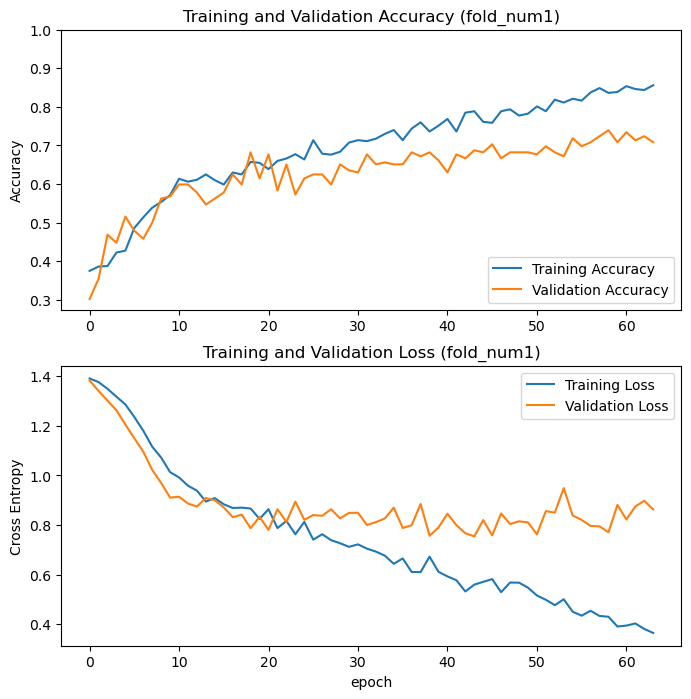

In [20]:


#Cell 15

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# val_tp = history.history['val_tp']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy'+' (fold_num' + str(fold_num)+')')



plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('Training and Validation Loss'+' (fold_num' + str(fold_num)+')')
plt.xlabel('epoch')
# plt.show()

plot_name = name_dir + '/Training and Validation'+'(fold_num'+ str(fold_num) +')'+ '.png'
plt.savefig(plot_name)


In [21]:


# #Cell 16

# print('Min val_loss=' + str(np.min(val_loss)) +'      val_acc='+ str(val_acc[np.argmin(val_loss)]))


In [22]:

#Cell 17

np.argmin(val_loss)

43

In [23]:


#Cell 18


import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes,
                        normalize=False,
                        title=None,
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes#[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes, yticklabels=classes,
        title=title,
        ylabel='True label',
        xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax



Found 200 validated image filenames belonging to 4 classes.
(200, 420, 640, 3)


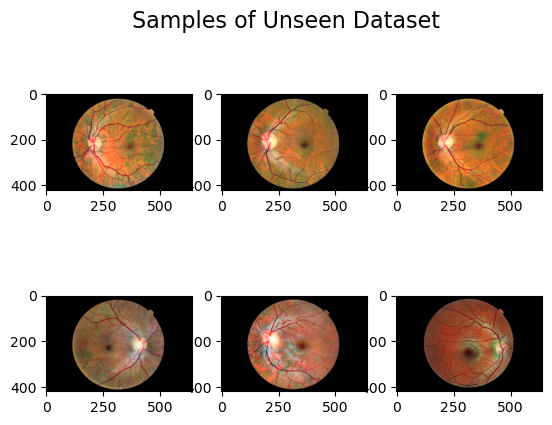

7/7 [==============================] - 7s 355ms/step


In [24]:


#Cell 19


valid_test_generator = valid_datagen.flow_from_dataframe(
    dataframe = df_valid,
    directory = valid_data_dir,
    x_col =  X_col, #LayerName,
    y_col = ClassNameVar,
#     target_size = (img_width, img_height),
    target_size = (img_height, img_width),
    class_mode = class_mode,
    color_mode = 'rgb',
    shuffle=False,
    batch_size = len(df_valid))

#
X, y_true = [], []
#

i = 0
while i < 1:
    temp_X, temp_y_true = valid_test_generator.next()
    if i < 1:
        X = temp_X
        y_true = temp_y_true
    else:
        X = np.concatenate((X, temp_X), axis=0)
        y_true = np.concatenate((y_true, temp_y_true), axis = 0)
    i += 1
print(X.shape)
for k in range(1,7):
    sample_img = X[k,:,:,:]
    plt.subplot(2, 3, k)
    plt.imshow(sample_img)
plt.suptitle('Samples of Unseen Dataset', fontsize = 16)
plt.show()



if len(class_names) == 1:
    y_pred = np.around(model.predict(X),0)
    y_pred = np.reshape(y_pred, (1, len(y_pred)))
    y_pred = y_pred[0]
else:
    y_pred = model.predict(X)



In [25]:
# Initialize lists to store correct and incorrect predictions
correct_rows = []
incorrect_rows = []

# Loop through the predictions and true labels
for i in range(len(X)):
    img_name = df_valid.iloc[i][X_col]  # Assuming LayerName contains the image filename
    true_label = y_true.argmax(axis=1)[i]
    pred_label = y_pred.argmax(axis=1)[i]
#     print(f'true_label {true_label} pred_label {np.round(pred_label)} ')
    # Check if the prediction is correct
    if np.array_equal(true_label, pred_label):
        correct_rows.append(df_valid.iloc[i])  # Save correct row
    else:
        incorrect_rows.append(df_valid.iloc[i])  # Save incorrect row

# Convert lists to DataFrames
df_correct = pd.DataFrame(correct_rows)
df_incorrect = pd.DataFrame(incorrect_rows)

# Save the DataFrames to CSV files
df_correct.to_csv(name_dir + '/correct_valid_predictions'+str(fold_num)+'.csv', index=False)
df_incorrect.to_csv(name_dir + '/incorrect_valid_predictions'+str(fold_num)+'.csv', index=False)

print(f'Saved {len(correct_rows)} correct predictions and {len(incorrect_rows)} incorrect predictions. Valid')

Saved 146 correct predictions and 54 incorrect predictions. Valid


Categorical Classification
---------------------
Confusion matrix, without normalization
[[74 11  6  2]
 [10  6  9  0]
 [ 4  3 29  2]
 [ 0  2  5 37]]
[[74 11  6  2]
 [10  6  9  0]
 [ 4  3 29  2]
 [ 0  2  5 37]]


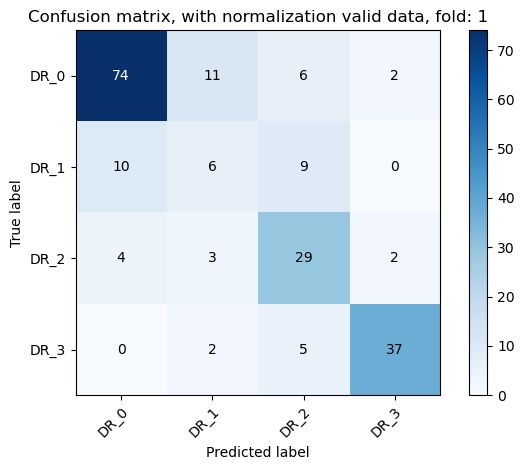

In [26]:

#Cell 20

title_mat = 'Confusion matrix, with normalization valid data, fold: ' + str(fold_num)
plot_name = name_dir + '/confusion_matrix_valid_fold' + str(fold_num) +'_'+LayerName+ '.png'
if len(class_names) == 1:
    print('Binary Classification')
    print('---------------------')
    plot_confusion_matrix(y_true,
                        y_pred,
                        classes = class_names,
                        normalize = False,
                        title = title_mat)
    plt.savefig(plot_name)
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

else:
    print('Categorical Classification')
    print('---------------------')
    plot_confusion_matrix(y_true.argmax(axis=1),
                        y_pred.argmax(axis=1),
                        classes = class_names,
                        normalize = False,
                        title = title_mat)
    plt.savefig(plot_name)
    cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
    print(cm)

cm1 = cm

CM_name = name_dir + '/CM_valid_'+ str(fold_num) + '_' +LayerName + '.csv'
pd.DataFrame(cm1).to_csv(CM_name,index=False)

plt.show()


In [27]:

    
#Cell 21
# Disease      TP      FN
#       True
# Healthy      FP      TN
#         Disease     Healthy
#                Pred

def binAccuracy(mat2D):
    tp = mat2D[0][0]
    tn = mat2D[1][1]
    fp = mat2D[1][0]
    fn = mat2D[0][1]
    res = (tp+tn) / (tp+tn+fp+fn)
    return res

def binSensitivity(mat2D):
    tp = mat2D[0][0]
    tn = mat2D[1][1]
    fp = mat2D[1][0]
    fn = mat2D[0][1]
    res = tp / (tp+fn)
    return res


def binSpecificity(mat2D):
    tp = mat2D[0][0]
    tn = mat2D[1][1]
    fp = mat2D[1][0]
    fn = mat2D[0][1]
    res = tn / (tn+fp)
    return res


In [28]:
def creat2DConfusionMatrix(categoryIndex, conf_mat, sizeofCategory = class_names):
  mat2D_var =np.array(([0,0],[0,0]))
  mat2D_var[0][0] = conf_mat[categoryIndex][categoryIndex]
  # print("mat2D_var[0][0]:  {} {}".format(categoryIndex, categoryIndex))
  for intI in range(0,len(sizeofCategory)):
    if intI != categoryIndex:
      mat2D_var[0][1] += conf_mat[categoryIndex][intI]
      # print("mat2D_var[0][1]:  {} {}".format(categoryIndex, intI))
      mat2D_var[1][0] += conf_mat[intI][categoryIndex]
      # print("mat2D_var[1][0]:  {} {}".format(intI, categoryIndex))

  for intI in range(0,len(sizeofCategory)):
    for intJ in range(0,len(sizeofCategory)):
      if intI != categoryIndex and intJ != categoryIndex:
        mat2D_var[1][1] += conf_mat[intI][intJ]
        # print("mat2D_var[1][1]:  {} {}".format(intI, intJ))

  return mat2D_var


In [29]:
def accuracyCalculator(conf_mat):
  mat2D_var =np.array(([0,0],[0,0]))
  mat2D_var = creat2DConfusionMatrix(0,conf_mat)
  C1_acc = binAccuracy(mat2D_var)

  mat2D_var =np.array(([0,0],[0,0]))
  mat2D_var = creat2DConfusionMatrix(1,conf_mat)
  C2_acc = binAccuracy(mat2D_var)

  mat2D_var =np.array(([0,0],[0,0]))
  mat2D_var = creat2DConfusionMatrix(2,conf_mat)
  C3_acc = binAccuracy(mat2D_var)

  mat2D_var =np.array(([0,0],[0,0]))
  mat2D_var = creat2DConfusionMatrix(3,conf_mat)
  C4_acc = binAccuracy(mat2D_var)

  result = []
  result.append([C1_acc,C2_acc,C3_acc, C4_acc])

  return np.squeeze(result)
###########################################################
def sensitivityCalculator(conf_mat):
  mat2D_var =np.array(([0,0],[0,0]))
  mat2D_var = creat2DConfusionMatrix(0,conf_mat)
  C1_acc = binSensitivity(mat2D_var)


  mat2D_var =np.array(([0,0],[0,0]))
  mat2D_var = creat2DConfusionMatrix(1,conf_mat)
  C2_acc = binSensitivity(mat2D_var)


  mat2D_var =np.array(([0,0],[0,0]))
  mat2D_var = creat2DConfusionMatrix(2,conf_mat)
  C3_acc = binSensitivity(mat2D_var)

  mat2D_var =np.array(([0,0],[0,0]))
  mat2D_var = creat2DConfusionMatrix(3,conf_mat)
  C4_acc = binSensitivity(mat2D_var)

  result = []
  result.append([C1_acc,C2_acc,C3_acc, C4_acc])

  return np.squeeze(result)
################################################################
def specificityCalculator(conf_mat):
  mat2D_var =np.array(([0,0],[0,0]))
  mat2D_var = creat2DConfusionMatrix(0,conf_mat)
  C1_acc = binSpecificity(mat2D_var)

  mat2D_var =np.array(([0,0],[0,0]))
  mat2D_var = creat2DConfusionMatrix(1,conf_mat)
  C2_acc = binSpecificity(mat2D_var)

  mat2D_var =np.array(([0,0],[0,0]))
  mat2D_var = creat2DConfusionMatrix(2,conf_mat)
  C3_acc = binSpecificity(mat2D_var)

  mat2D_var =np.array(([0,0],[0,0]))
  mat2D_var = creat2DConfusionMatrix(3,conf_mat)
  C4_acc = binSpecificity(mat2D_var)

  result = []
  result.append([C1_acc,C2_acc,C3_acc, C4_acc])

  return np.squeeze(result)


In [30]:

#Cell 25

param_dict = {
    'class_weights':class_weights,
    'fold_num': fold_num,
    'num_classes': num_classes,
    'epochs': epochs,
    'batch_size': batch_size,
    'learning_rate': learning_rate,
    'img_width': img_width,
    'img_height': img_height,
    'img_depth': img_depth,
    'act_type': act_type,
    'class_mode': class_mode,
    'loss_fun': loss_fun,
    'train_false_layer': train_false_layer,
    'train_valid_split': train_valid_split,
    'data_dir': data_dir,
    'valid_data_dir': valid_data_dir,
    'name_dir': name_dir
}
#

f = open(os.path.join(name_dir, 'train_param_valid.txt'), 'w')
f.write( 'dict = ' + repr(param_dict) + '\n' )
f.write( 'data_gen = ' + repr(data_gen_args) + '\n')
f.write( 'cm1 = ' + repr(cm1) + '\n')
f.write( 'accuracyCalculator = ' + repr(accuracyCalculator(cm1)) + '\n')
f.write( 'sensitivityCalculator = ' + repr(sensitivityCalculator(cm1)) + '\n')
f.write( 'specificityCalculator = ' + repr(specificityCalculator(cm1)) + '\n')
f.write( 'Min val_loss_'+ repr(np.argmin(val_loss)) + ' = '+ str(np.min(val_loss)) +'      val_acc='+ str(val_acc[np.argmin(val_loss)]) + '\n')
f.write( 'Max val_acc_'+ repr(np.argmax(val_acc)) + ' = '+ str(np.max(val_acc)) +'      val_loss='+ str(val_loss[np.argmax(val_acc)]) + '\n')
# f.write( 'Max val_tp_'+ repr(np.argmax(val_tp)) + ' = '+ str(np.max(val_tp)) +'      val_loss='+ str(val_loss[np.argmax(val_tp)]) + '      val_acc='+ str(val_acc[np.argmax(val_tp)]) + '\n')
f.write( 'monitorFor_es4 : '+ str(monitorFor_es4) + '\n')
f.write( 'patienceFor_es4 : '+ str(patienceFor_es4) + '\n')

model.summary(print_fn=lambda x: f.write(x + '\n'))


f.write(str(''.join(filterChannelFuncRepr)) + '\n' )
f.close()



In [31]:

#Cell 26

from sklearn.metrics import roc_curve, auc
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


def AUC_Multiclass(classNames,yTrue,yPred):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(classNames)):
        fpr[i], tpr[i], _ = roc_curve(yTrue[:, i], yPred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot of a ROC curve for a specific class
    plt.figure()
    for i in range(len(classNames)):
        plt.plot(fpr[i], tpr[i], label= str(classNames[i])+ ' (area = %0.2f)' % roc_auc[i])
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")


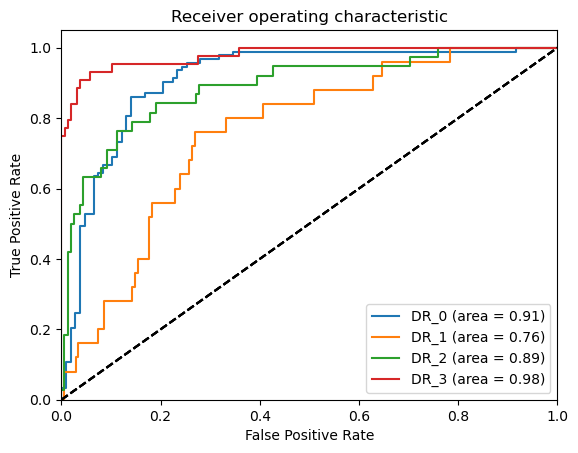

In [32]:
#Cell 27

yTrue1 = y_true
yPred1 = y_pred

AUC_Multiclass(class_names,yTrue1,yPred1)
plot_name = name_dir + '/AUC_Valid_fold' + str(fold_num) + '_'+LayerName+ '.png'
plt.savefig(plot_name)

plt.show()

# import gc
# del model,df_train,data_dir,train_generator,df_test,test_data_dir,valid_generator,test_generator
# gc.collect()

In [33]:
################ Now test unseen data

Found 57 validated image filenames belonging to 4 classes.
(57, 420, 640, 3)


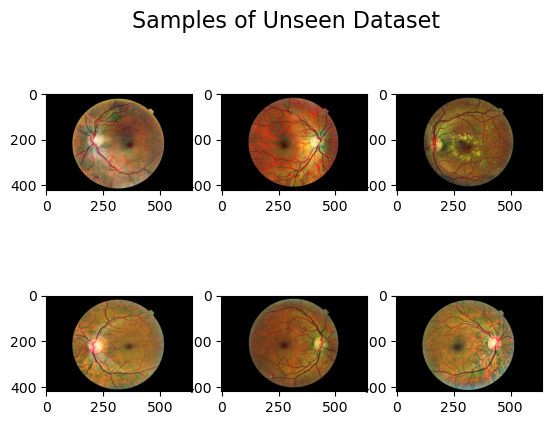

2/2 [==============================] - 2s 2s/step


In [34]:


#Cell 19



unseen_data_gen_args = dict(
    rescale = 1./255,
)

unseen_datagen = ImageDataGenerator(
    **unseen_data_gen_args)

unseen_generator = unseen_datagen.flow_from_dataframe(
    dataframe = df_unseen,
    directory = unseen_data_dir,
#     target_size = (img_width, img_height),
    target_size = (img_height, img_width),

    x_col = X_col, #LayerName,
    y_col = ClassNameVar,
    class_mode = class_mode,
    color_mode = 'rgb',
    shuffle=False,
    batch_size = len(df_unseen))

#
X, y_true = [], []
#
# print(len(df_test))
i = 0
while i < 1:
    temp_X, temp_y_true = unseen_generator.next()
    if i < 1:
        X = temp_X
        y_true = temp_y_true
    else:
        X = np.concatenate((X, temp_X), axis=0)
        y_true = np.concatenate((y_true, temp_y_true), axis = 0)
    i += 1
print(X.shape)
for k in range(1,7):
    sample_img = X[k,:,:,:]
    plt.subplot(2, 3, k)
    plt.imshow(sample_img)
plt.suptitle('Samples of Unseen Dataset', fontsize = 16)
plt.show()



if len(class_names) == 1:
    y_pred = np.around(model.predict(X),0)
    y_pred = np.reshape(y_pred, (1, len(y_pred)))
    y_pred = y_pred[0]
else:
    y_pred = model.predict(X)



In [35]:
# y_pred

In [36]:
# y_true

In [37]:
# Initialize lists to store correct and incorrect predictions
correct_rows = []
incorrect_rows = []

# Loop through the predictions and true labels
for i in range(len(X)):
    img_name = df_unseen.iloc[i][X_col]  # Assuming LayerName contains the image filename
    true_label = y_true.argmax(axis=1)[i]
    pred_label = y_pred.argmax(axis=1)[i]
#     print(f'true_label {true_label} pred_label {np.round(pred_label)} ')
    # Check if the prediction is correct
    if np.array_equal(true_label, pred_label):
        correct_rows.append(df_unseen.iloc[i])  # Save correct row
    else:
        incorrect_rows.append(df_unseen.iloc[i])  # Save incorrect row

# Convert lists to DataFrames
df_correct = pd.DataFrame(correct_rows)
df_incorrect = pd.DataFrame(incorrect_rows)

# Save the DataFrames to CSV files
df_correct.to_csv(name_dir + '/correct_unseen_predictions'+str(fold_num)+'.csv', index=False)
df_incorrect.to_csv(name_dir + '/incorrect_unseen_predictions'+str(fold_num)+'.csv', index=False)

print(f'Saved {len(correct_rows)} correct predictions and {len(incorrect_rows)} incorrect predictions. Unseen')

Saved 43 correct predictions and 14 incorrect predictions. Unseen


Categorical Classification
---------------------
Confusion matrix, without normalization
[[24  1  1  0]
 [ 4  2  1  0]
 [ 1  2  7  1]
 [ 0  0  3 10]]
[[24  1  1  0]
 [ 4  2  1  0]
 [ 1  2  7  1]
 [ 0  0  3 10]]


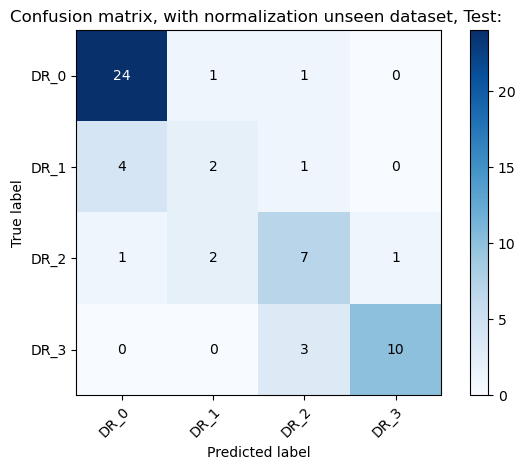

In [38]:

#Cell 20

title_mat = 'Confusion matrix, with normalization unseen dataset, Test: '
plot_name = name_dir + '/confusion_matrix_unseen_' + LayerName+'.png'
if len(class_names) == 1:
    print('Binary Classification')
    print('---------------------')
    plot_confusion_matrix(y_true,
                        y_pred,
                        classes = class_names,
                        normalize = False,
                        title = title_mat)
    plt.savefig(plot_name)
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

else:
    print('Categorical Classification')
    print('---------------------')
    plot_confusion_matrix(y_true.argmax(axis=1),
                        y_pred.argmax(axis=1),
                        classes = class_names,
                        normalize = False,
                        title = title_mat)
    plt.savefig(plot_name)
    cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
    print(cm)

cm1 = cm

CM_name = name_dir + '/CM_Unseen_fromWeightFold_'+ str(fold_num) + '_' +LayerName +'.csv'
pd.DataFrame(cm1).to_csv(CM_name,index=False)

plt.show()


In [39]:

#Cell 25

param_dict = {
    'class_weights':class_weights,
    'fold_num': fold_num,
    'num_classes': num_classes,
    'epochs': epochs,
    'batch_size': batch_size,
    'learning_rate': learning_rate,
    'img_width': img_width,
    'img_height': img_height,
    'img_depth': img_depth,
    'act_type': act_type,
    'class_mode': class_mode,
    'loss_fun': loss_fun,
    'train_false_layer': train_false_layer,
    'train_valid_split': train_valid_split,
    'data_dir': data_dir,
    'test_data_dir': unseen_data_dir,
    'name_dir': name_dir
}
#

f = open(os.path.join(name_dir, 'train_param_unseen.txt'), 'w')
f.write( 'dict = ' + repr(param_dict) + '\n' )
f.write( 'data_gen = ' + repr(data_gen_args) + '\n')
f.write( 'cm1 = ' + repr(cm1) + '\n')
f.write( 'accuracyCalculator = ' + repr(accuracyCalculator(cm1)) + '\n')
f.write( 'sensitivityCalculator = ' + repr(sensitivityCalculator(cm1)) + '\n')
f.write( 'specificityCalculator = ' + repr(specificityCalculator(cm1)) + '\n')
f.write( 'Min val_loss_'+ repr(np.argmin(val_loss)) + ' = '+ str(np.min(val_loss)) +'      val_acc='+ str(val_acc[np.argmin(val_loss)]) + '\n')
f.write( 'Max val_acc_'+ repr(np.argmax(val_acc)) + ' = '+ str(np.max(val_acc)) +'      val_loss='+ str(val_loss[np.argmax(val_acc)]) + '\n')
# f.write( 'Max val_tp_'+ repr(np.argmax(val_tp)) + ' = '+ str(np.max(val_tp)) +'      val_loss='+ str(val_loss[np.argmax(val_tp)]) + '      val_acc='+ str(val_acc[np.argmax(val_tp)]) + '\n')
f.write( 'monitorFor_es4 : '+ str(monitorFor_es4) + '\n')
f.write( 'patienceFor_es4 : '+ str(patienceFor_es4) + '\n')

model.summary(print_fn=lambda x: f.write(x + '\n'))


f.write(str(''.join(filterChannelFuncRepr)) + '\n' )
f.close()



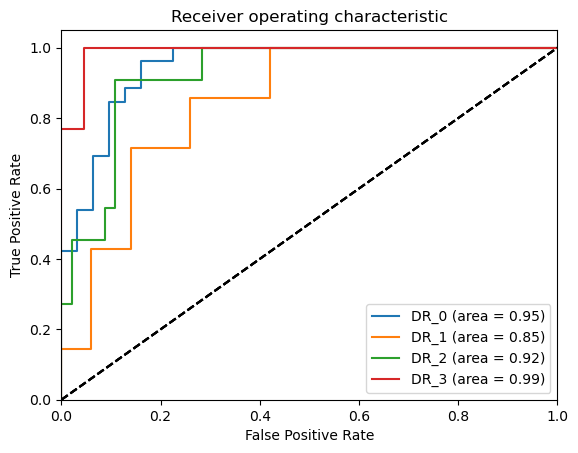

In [40]:
#Cell 27

yTrue1 = y_true
yPred1 = y_pred

AUC_Multiclass(class_names,yTrue1,yPred1)
plot_name = name_dir + '/AUC_Unseen_fromWeightFold_'+ str(fold_num) + '_' + LayerName + '.png'
plt.savefig(plot_name)

plt.show()

